# **Required Libraries**

In [29]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm as lgb
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, f1_score, roc_auc_score
from sklearn.model_selection import RandomizedSearchCV


In [2]:
# Paths for the data files
dev_data = pd.read_csv("C:\\Users\\11a24\\Documents\\Convolve\\Dev_data_to_be_shared.csv") # Replace the paths
validation_data = pd.read_csv("C:\\Users\\11a24\\Documents\\Convolve\\validation_data_to_be_shared.csv") # Replace the paths

In [3]:
df_dev = dev_data
df_val= validation_data
df_dev.dtypes

account_number               int64
bad_flag                     int64
onus_attribute_1           float64
transaction_attribute_1    float64
transaction_attribute_2    float64
                            ...   
onus_attribute_44          float64
onus_attribute_45          float64
onus_attribute_46          float64
onus_attribute_47          float64
onus_attribute_48          float64
Length: 1216, dtype: object

# **Data Preprocessing**

In [4]:
# Define feature categories
onus_attributes = [col for col in df_dev.columns if col.startswith("onus_attribute")]
transaction_attributes = [col for col in df_dev.columns if col.startswith("transaction_attribute")]
bureau_attributes = [col for col in df_dev.columns if col.startswith("bureau") and not col.startswith("bureau_enquiry")]
bureau_enquiry_attributes = [col for col in df_dev.columns if col.startswith("bureau_enquiry")]

feature_counts = {
    "On-Us Attributes": len(onus_attributes),
    "Transaction Attributes": len(transaction_attributes),
    "Bureau Attributes": len(bureau_attributes),
    "Bureau Enquiry Attributes": len(bureau_enquiry_attributes),
}

# Count features in each category
print(f"Number of On-Us Attributes: {len(onus_attributes)}")
print(f"Number of Transaction Attributes: {len(transaction_attributes)}")
print(f"Number of Bureau Attributes: {len(bureau_attributes)}")
print(f"Number of Bureau Enquiry Attributes: {len(bureau_enquiry_attributes)}")

Number of On-Us Attributes: 48
Number of Transaction Attributes: 664
Number of Bureau Attributes: 452
Number of Bureau Enquiry Attributes: 50


In [5]:
# Calculate the percentage of null values for each feature
null_percentage = df_dev.isnull().mean() * 100

# Filter features with more than 35% null values
features_with_high_nulls = null_percentage[null_percentage > 35]

# Print the features and their corresponding null percentages
print("Features with more than 35% null values:")
print(features_with_high_nulls)


Features with more than 35% null values:
bureau_148            93.552053
bureau_433            76.215317
bureau_434            42.237051
bureau_435            76.948743
bureau_436           100.000000
bureau_437            67.461728
bureau_438            85.539119
bureau_444            87.742495
bureau_445            53.688821
bureau_446            83.377063
bureau_447           100.000000
bureau_448            90.028511
bureau_449            94.124331
bureau_451            57.208231
onus_attribute_6      36.839659
onus_attribute_7      46.437204
onus_attribute_43     88.006942
onus_attribute_44     88.006942
onus_attribute_45     88.006942
onus_attribute_46     88.006942
onus_attribute_47     88.006942
onus_attribute_48     88.006942
dtype: float64


In [6]:
df_dev['bad_flag'].value_counts()

bad_flag
0    95434
1     1372
Name: count, dtype: int64

In [7]:
# Filter rows where 'bad_flag' is 1
bad_flag_rows = df_dev[df_dev['bad_flag'] == 1]

# Display the rows
print(bad_flag_rows.head(10))


     account_number  bad_flag  onus_attribute_1  transaction_attribute_1  \
141             142         1           58000.0                      0.0   
246             247         1          331000.0                      0.0   
289             290         1           74000.0                      0.0   
351             352         1           43000.0                      0.0   
476             477         1           89000.0                      0.0   
523             524         1               NaN                      NaN   
577             578         1           25000.0                      0.0   
630             631         1           25000.0                      0.0   
683             684         1               NaN                      NaN   
815             816         1          146000.0                      0.0   

     transaction_attribute_2  transaction_attribute_3  \
141                      0.0                      0.0   
246                      0.0                     

In [8]:
# Define the threshold for NaN values
threshold = 0.35 * df_dev.shape[1]  # 35% of the total columns

# Identify rows with NaN values greater than the threshold and bad_flag = 0
mask = (df_dev.isna().sum(axis=1) > threshold) & (df_dev['bad_flag'] == 0)

# Remove those rows from the dataframe
df_dev = df_dev[~mask].reset_index(drop=True)

# Display the result
print(df_dev.shape)


(70975, 1216)


In [9]:
# Define the threshold for NaN values
threshold = 0.35 * df_dev.shape[0]  # 35% of the total rows

# Identify columns where NaN values exceed the threshold
columns_to_drop = df_dev.columns[df_dev.isna().sum(axis=0) > threshold]

# Drop those columns
df_dev = df_dev.drop(columns=columns_to_drop)

# Display the result
print(f"Columns dropped: {list(columns_to_drop)}")
print(f"Remaining columns: {df_dev.shape[1]}")


Columns dropped: ['bureau_148', 'bureau_433', 'bureau_434', 'bureau_435', 'bureau_436', 'bureau_437', 'bureau_438', 'bureau_444', 'bureau_445', 'bureau_446', 'bureau_447', 'bureau_448', 'bureau_449', 'bureau_451', 'onus_attribute_6', 'onus_attribute_7', 'onus_attribute_43', 'onus_attribute_44', 'onus_attribute_45', 'onus_attribute_46', 'onus_attribute_47', 'onus_attribute_48']
Remaining columns: 1194


In [10]:
# Identify columns with only one unique value
columns_to_drop = [col for col in df_dev.columns if df_dev[col].nunique() == 1]

# Drop those columns
df_dev = df_dev.drop(columns=columns_to_drop)

# Display the result
print(f"Columns dropped: {columns_to_drop}")
print(f"Remaining columns: {df_dev.shape[1]}")


Columns dropped: ['transaction_attribute_152', 'transaction_attribute_191', 'transaction_attribute_524', 'transaction_attribute_525', 'transaction_attribute_582', 'transaction_attribute_621', 'bureau_4', 'bureau_16', 'bureau_26', 'bureau_38', 'bureau_47', 'bureau_56', 'bureau_70', 'bureau_80', 'bureau_90', 'bureau_100', 'bureau_110', 'bureau_120', 'bureau_131', 'bureau_142', 'bureau_152', 'bureau_162', 'bureau_172', 'bureau_182', 'bureau_192', 'bureau_202', 'bureau_212', 'bureau_222', 'bureau_232', 'bureau_242', 'bureau_252', 'bureau_262', 'bureau_272', 'bureau_282', 'bureau_292', 'bureau_302', 'bureau_312', 'bureau_322', 'bureau_332', 'bureau_342', 'bureau_352', 'bureau_362', 'bureau_372', 'bureau_382', 'bureau_392', 'bureau_402', 'bureau_412', 'bureau_423', 'onus_attribute_28', 'bureau_enquiry_7', 'bureau_enquiry_17', 'bureau_enquiry_27', 'bureau_enquiry_37', 'bureau_enquiry_47']
Remaining columns: 1140


In [11]:
uniq = df_dev.nunique()
print(uniq)

account_number             70975
bad_flag                       2
onus_attribute_1             968
transaction_attribute_1       82
transaction_attribute_2        8
                           ...  
bureau_enquiry_45             86
bureau_enquiry_46             26
bureau_enquiry_48             14
bureau_enquiry_49             15
bureau_enquiry_50             88
Length: 1140, dtype: int64


In [12]:
# Define the prefixes
prefixes = ['onus_attribute', 'transaction_attribute_', 'bureau_enquiry', 'bureau']

# Initialize a dictionary to store the counts
feature_counts = {prefix: 0 for prefix in prefixes}

# Count features for each prefix
for prefix in prefixes:
    feature_counts[prefix] = len([col for col in df_dev.columns if col.startswith(prefix)])

# Display the counts
for prefix, count in feature_counts.items():
    print(f"Number of features starting with '{prefix}': {count}")


Number of features starting with 'onus_attribute': 39
Number of features starting with 'transaction_attribute_': 658
Number of features starting with 'bureau_enquiry': 45
Number of features starting with 'bureau': 441


In [13]:
# Initialize empty lists for each category
onus_attribute_features = []
transaction_attribute_features = []
bureau_enquiry_features = []
bureau_features = []

# Populate the lists based on the column prefixes
for col in df_dev.columns:
    if col.startswith('onus_attribute'):
        onus_attribute_features.append(col)
    elif col.startswith('transaction_attribute_'):
        transaction_attribute_features.append(col)
    elif col.startswith('bureau_enquiry'):
        bureau_enquiry_features.append(col)
    elif col.startswith('bureau'):
        bureau_features.append(col)

# Display the counts and sample features for verification
print(f"Number of features in 'onus_attribute': {len(onus_attribute_features)}")
print(f"Number of features in 'transaction_attribute_': {len(transaction_attribute_features)}")
print(f"Number of features in 'bureau_enquiry': {len(bureau_enquiry_features)}")
print(f"Number of features in 'bureau': {len(bureau_features)}")

# (Optional) Example of accessing the feature lists
print("Sample 'onus_attribute' features:", onus_attribute_features[:5])
print("Sample 'transaction_attribute_' features:", transaction_attribute_features[:5])


Number of features in 'onus_attribute': 39
Number of features in 'transaction_attribute_': 658
Number of features in 'bureau_enquiry': 45
Number of features in 'bureau': 396
Sample 'onus_attribute' features: ['onus_attribute_1', 'onus_attribute_2', 'onus_attribute_3', 'onus_attribute_4', 'onus_attribute_5']
Sample 'transaction_attribute_' features: ['transaction_attribute_1', 'transaction_attribute_2', 'transaction_attribute_3', 'transaction_attribute_4', 'transaction_attribute_5']


In [14]:
df_dev.shape

(70975, 1140)

**Correlation Analysis**

In [16]:
import numpy as np

# Function to remove highly correlated features
def remove_highly_correlated_features(df, feature_list, threshold=0.9):
    # Subset the dataframe with the relevant features
    df_subset = df[feature_list]

    # Compute the correlation matrix
    corr_matrix = df_subset.corr().abs()

    # Extract the upper triangle of the correlation matrix to avoid double counting
    upper_triangle = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

    # Identify columns with correlation above the threshold
    to_drop = [column for column in upper_triangle.columns if any(upper_triangle[column] > threshold)]

    # Drop the identified columns
    df_subset = df_subset.drop(columns=to_drop)

    return df_subset, to_drop

# Apply for each set of features
onus_attribute_cleaned, onus_attribute_dropped = remove_highly_correlated_features(df_dev, onus_attribute_features)
transaction_attribute_cleaned, transaction_attribute_dropped = remove_highly_correlated_features(df_dev, transaction_attribute_features)
bureau_enquiry_cleaned, bureau_enquiry_dropped = remove_highly_correlated_features(df_dev, bureau_enquiry_features)
bureau_cleaned, bureau_dropped = remove_highly_correlated_features(df_dev, bureau_features)

# Display results
print(f"Remaining features in 'onus_attribute': {len(onus_attribute_cleaned.columns)}")
print(f"Remaining features in 'transaction_attribute_': {len(transaction_attribute_cleaned.columns)}")
print(f"Remaining features in 'bureau_enquiry': {len(bureau_enquiry_cleaned.columns)}")
print(f"Remaining features in 'bureau': {len(bureau_cleaned.columns)}")

# Optionally, display the dropped features for each set
print("\nDropped features from 'onus_attribute':", onus_attribute_dropped)
print("Dropped features from 'transaction_attribute_':", transaction_attribute_dropped)
print("Dropped features from 'bureau_enquiry':", bureau_enquiry_dropped)
print("Dropped features from 'bureau':", bureau_dropped)


Remaining features in 'onus_attribute': 23
Remaining features in 'transaction_attribute_': 456
Remaining features in 'bureau_enquiry': 32
Remaining features in 'bureau': 274

Dropped features from 'onus_attribute': ['onus_attribute_12', 'onus_attribute_13', 'onus_attribute_14', 'onus_attribute_15', 'onus_attribute_16', 'onus_attribute_20', 'onus_attribute_21', 'onus_attribute_22', 'onus_attribute_23', 'onus_attribute_24', 'onus_attribute_25', 'onus_attribute_37', 'onus_attribute_38', 'onus_attribute_39', 'onus_attribute_41', 'onus_attribute_42']
Dropped features from 'transaction_attribute_': ['transaction_attribute_9', 'transaction_attribute_15', 'transaction_attribute_30', 'transaction_attribute_39', 'transaction_attribute_51', 'transaction_attribute_60', 'transaction_attribute_66', 'transaction_attribute_80', 'transaction_attribute_81', 'transaction_attribute_87', 'transaction_attribute_103', 'transaction_attribute_104', 'transaction_attribute_105', 'transaction_attribute_106', 'tra

In [17]:
# Calculate the percentage of null values for each feature
null_percentage = df_dev.isnull().mean() * 100

# Filter features with more than 35% null values
features_with_high_nulls = null_percentage[null_percentage > 0]

# Print the features and their corresponding null percentages
print("Features with more than 35% null values:")
print(features_with_high_nulls)


Features with more than 35% null values:
onus_attribute_1           0.453681
transaction_attribute_1    0.453681
transaction_attribute_2    0.453681
transaction_attribute_3    0.453681
transaction_attribute_4    0.453681
                             ...   
bureau_enquiry_45          1.568158
bureau_enquiry_46          1.568158
bureau_enquiry_48          1.568158
bureau_enquiry_49          1.568158
bureau_enquiry_50          1.568158
Length: 1110, dtype: float64


In [18]:
df_dev = df_dev[
    list(onus_attribute_cleaned.columns) +
    list(transaction_attribute_cleaned.columns) +
    list(bureau_enquiry_cleaned.columns) +
    list(bureau_cleaned.columns) +
    ['account_number', 'bad_flag']  
]


In [19]:
df_dev.shape
print(f"Shape of df_dev: {df_dev.shape}")

# Count the occurrences of 1s and 0s in the 'bad_flag' column
bad_flag_counts = df_dev['bad_flag'].value_counts()

# Display the counts
print("Count of bad_flag values:")
print(bad_flag_counts)
print(1372/(1372+69603))

Shape of df_dev: (70975, 787)
Count of bad_flag values:
bad_flag
0    69603
1     1372
Name: count, dtype: int64
0.019330750264177528


# **Models**

**Random Forests**

In [ ]:
# Random Forests
# Step 1: Separate features (X) and target (y)
X = df_dev.drop(columns=['bad_flag', 'account_number'])  # Drop target and account_number from features
y = df_dev['bad_flag']  # Target variable

# Step 2: Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Step 3: Train the Random Forest model
rf_model = RandomForestClassifier(n_estimators=200, random_state=42)  # You can adjust n_estimators and other hyperparameters
rf_model.fit(X_train, y_train)

# Step 4: Make predictions and evaluate the model
y_pred = rf_model.predict(X_test)

# Print accuracy
print(f"Accuracy: {accuracy_score(y_test, y_pred)}")

# Print F1 Score
f1 = f1_score(y_test, y_pred)
print(f"F1 Score: {f1}")

print(f"AUC Score: {roc_auc_score(y_test, y_pred)}")

# Print classification report
print("Classification Report:")
print(classification_report(y_test, y_pred))


Accuracy: 0.9859105318774216
F1 Score: 0.42528735632183906
AUC Score: 0.635036496350365
Classification Report:
              precision    recall  f1-score   support

           0       0.99      1.00      0.99     13921
           1       1.00      0.27      0.43       274

    accuracy                           0.99     14195
   macro avg       0.99      0.64      0.71     14195
weighted avg       0.99      0.99      0.98     14195



**XGBoost**

In [ ]:
# Train XGBoost Classifier
xgb_model = XGBClassifier(n_estimators=100, random_state=42, use_label_encoder=False, eval_metric='logloss')
xgb_model.fit(X_train, y_train)

# Make predictions
y_pred_xgb = xgb_model.predict(X_test)

# Evaluate XGBoost model
print("XGBoost Performance:")
print(f"Accuracy: {accuracy_score(y_test, y_pred_xgb)}")
print(f"AUC Score: {roc_auc_score(y_test, y_pred_xgb)}")
print(f"F1 Score: {f1_score(y_test, y_pred_xgb)}")
print("Classification Report:")
print(classification_report(y_test, y_pred_xgb))

c:\Users\11a24\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [23:38:46] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGBoost Performance:
Accuracy: 0.9858400845368087
AUC Score: 0.6367894799486361
F1 Score: 0.42735042735042733
Classification Report:
              precision    recall  f1-score   support

           0       0.99      1.00      0.99     13921
           1       0.97      0.27      0.43       274

    accuracy                           0.99     14195
   macro avg       0.98      0.64      0.71     14195
weighted avg       0.99      0.99      0.98     14195



**LightGBM**

In [ ]:
# Train LightGBM model
lgb_model = lgb.LGBMClassifier(
    n_estimators=100,
    learning_rate=0.05,
    num_leaves=31,
    random_state=42
)

lgb_model.fit(X_train, y_train)

# Predict and evaluate
y_pred_lgb = lgb_model.predict(X_test)
y_pred_proba_lgb = lgb_model.predict_proba(X_test)[:, 1]  # Get probabilities for the positive class

# Print performance metrics
print("LightGBM Performance:")
print(f"Accuracy: {accuracy_score(y_test, y_pred_lgb)}")
print(f"F1 Score: {f1_score(y_test, y_pred_lgb)}")
print(f"AUC Score: {roc_auc_score(y_test, y_pred_proba_lgb)}")
print("Classification Report:")
print(classification_report(y_test, y_pred_lgb))

[LightGBM] [Info] Number of positive: 1098, number of negative: 55682
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.294004 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 104207
[LightGBM] [Info] Number of data points in the train set: 56780, number of used features: 785
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.019338 -> initscore=-3.926167
[LightGBM] [Info] Start training from score -3.926167
LightGBM Performance:
Accuracy: 0.9858400845368087
F1 Score: 0.42406876790830944
AUC Score: 0.8779127474796518
Classification Report:
              precision    recall  f1-score   support

           0       0.99      1.00      0.99     13921
           1       0.99      0.27      0.42       274

    accuracy                           0.99     14195
   macro avg       0.99      0.64      0.71     14195
weighted avg       0.99      0.99      0.98     14195



**LIGHTGBM WITH RANDOMIZEDSEARCHCV HYPERPARATMER TUNING**

In [23]:
from sklearn.model_selection import RandomizedSearchCV
import numpy as np

# Define the model
lgb_model = lgb.LGBMClassifier(random_state=42)

# Define the parameter distributions
param_distributions = {
    'n_estimators': [100, 200],
    'learning_rate': [0.01, 0.05],
    'num_leaves': [15, 31],
    'reg_alpha': [0.1, 0.5, 1.0],
    'subsample': [0.8, 1.0],
}

# Initialize RandomizedSearchCV with the parameter distributions
random_search = RandomizedSearchCV(
    estimator=lgb_model,
    param_distributions=param_distributions,
    scoring='f1',  # Optimize for F1 score
    cv=5,          # 5-fold cross-validation
    verbose=2,     # Display progress
    n_jobs=4,      # Limit the number of parallel jobs
    n_iter=10,     # Number of iterations (reduce for faster testing)
    random_state=42
)

# Step 5: Fit RandomizedSearchCV to the data
random_search.fit(X_train, y_train)

# Get the best model and its parameters
best_lgb_model = random_search.best_estimator_

# Print the best parameters
print(f"Best Parameters: {random_search.best_params_}")


Fitting 5 folds for each of 10 candidates, totalling 50 fits
[LightGBM] [Info] Number of positive: 1098, number of negative: 55682
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.260422 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 104207
[LightGBM] [Info] Number of data points in the train set: 56780, number of used features: 785
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.019338 -> initscore=-3.926167
[LightGBM] [Info] Start training from score -3.926167
Best Parameters: {'subsample': 0.8, 'reg_alpha': 1.0, 'num_leaves': 15, 'n_estimators': 200, 'learning_rate': 0.05}


In [24]:
# Predict and evaluate the best model
y_pred_lgb = best_lgb_model.predict(X_test)
y_pred_proba_lgb = best_lgb_model.predict_proba(X_test)[:, 1]  # Get probabilities for the positive class

# Print performance metrics
print("Tuned LightGBM Performance:")
print(f"Accuracy: {accuracy_score(y_test, y_pred_lgb)}")
print(f"F1 Score: {f1_score(y_test, y_pred_lgb)}")
print(f"AUC Score: {roc_auc_score(y_test, y_pred_proba_lgb)}")
print("Classification Report:")
print(classification_report(y_test, y_pred_lgb))


Tuned LightGBM Performance:
Accuracy: 0.9859105318774216
F1 Score: 0.42528735632183906
AUC Score: 0.8761488839263477
Classification Report:
              precision    recall  f1-score   support

           0       0.99      1.00      0.99     13921
           1       1.00      0.27      0.43       274

    accuracy                           0.99     14195
   macro avg       0.99      0.64      0.71     14195
weighted avg       0.99      0.99      0.98     14195



# **Validation Dataset**

In [25]:
# Step 1: Prepare the data
# Remove target column ('bad_flag') from both df_dev and df_val
X_train = df_dev.drop(['bad_flag','account_number'], axis=1)  # Remove target from training set
y_train = df_dev['bad_flag']  # The target in df_dev

# Extract account numbers from df_val (make sure this column is preserved)
account_numbers = df_val['account_number']  # Account numbers from df_val

# Remove target column ('bad_flag') from df_val if it exists
X_val = df_val.drop(['bad_flag'], axis=1, errors='ignore')

# Step 2: Align the features between df_dev and df_val
# Ensure both datasets have the same columns by keeping only the common columns (excluding 'account_number')
common_columns = X_train.columns.intersection(X_val.columns)
X_train = X_train[common_columns]
X_val = X_val[common_columns]

# Step 3: Define the model with the best hyperparameters
best_params = {
    'subsample': 0.8,
    'reg_alpha': 1.0,
    'num_leaves': 15,
    'n_estimators': 200,
    'learning_rate': 0.05
}

# Initialize the LightGBM model with the best hyperparameters
lgb_model = lgb.LGBMClassifier(**best_params, random_state=42)

# Step 4: Train the model on the entire training dataset (df_dev)
lgb_model.fit(X_train, y_train)

# Step 5: Make predictions on the validation set (df_val)
y_pred_proba = lgb_model.predict_proba(X_val)[:, 1]  # Get probabilities for the positive class

# Step 6: Create a DataFrame with account_number and predicted probabilities
result_df = pd.DataFrame({
    'account_number': account_numbers,  # From df_val
    'predicted_probability': y_pred_proba  # Predicted probability for positive class
})

# Step 7: Save the results to a CSV file
result_df.to_csv('predicted_probabilities.csv', index=False)

print("Predictions have been saved to 'predicted_probabilities.csv'.")


[LightGBM] [Info] Number of positive: 1372, number of negative: 69603
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.367526 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 106465
[LightGBM] [Info] Number of data points in the train set: 70975, number of used features: 785
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.019331 -> initscore=-3.926538
[LightGBM] [Info] Start training from score -3.926538
Predictions have been saved to 'predicted_probabilities.csv'.


In [26]:
result_df.shape

(41792, 2)

In [27]:
result_df.head

<bound method NDFrame.head of        account_number  predicted_probability
0              100001               0.012955
1              100002               0.990490
2              100003               0.001916
3              100004               0.995262
4              100005               0.014959
...               ...                    ...
41787          141788               0.008014
41788          141789               0.003088
41789          141790               0.010737
41790          141791               0.004817
41791          141792               0.016455

[41792 rows x 2 columns]>

Basic Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41792 entries, 0 to 41791
Data columns (total 2 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   account_number         41792 non-null  int64  
 1   predicted_probability  41792 non-null  float64
dtypes: float64(1), int64(1)
memory usage: 653.1 KB
None

Summary Statistics of Predicted Probabilities:
count    41792.000000
mean         0.280835
std          0.436314
min          0.000210
25%          0.003186
50%          0.011599
75%          0.993063
max          0.999537
Name: predicted_probability, dtype: float64


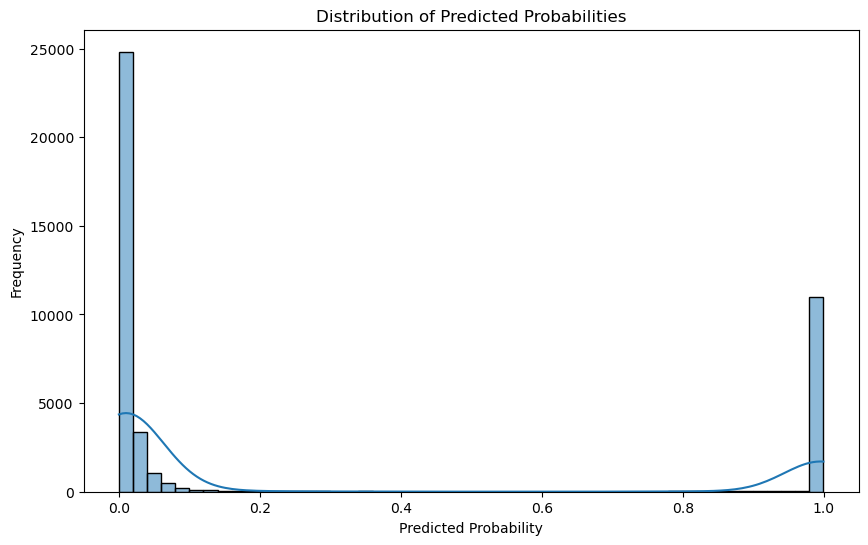


Null Values in result_df:
account_number           0
predicted_probability    0
dtype: int64

Number of Duplicate Account Numbers:
0

Min Probability: 0.00021016684340655978
Max Probability: 0.999537285721584

Number of positive class predictions (> 0.5): 11392


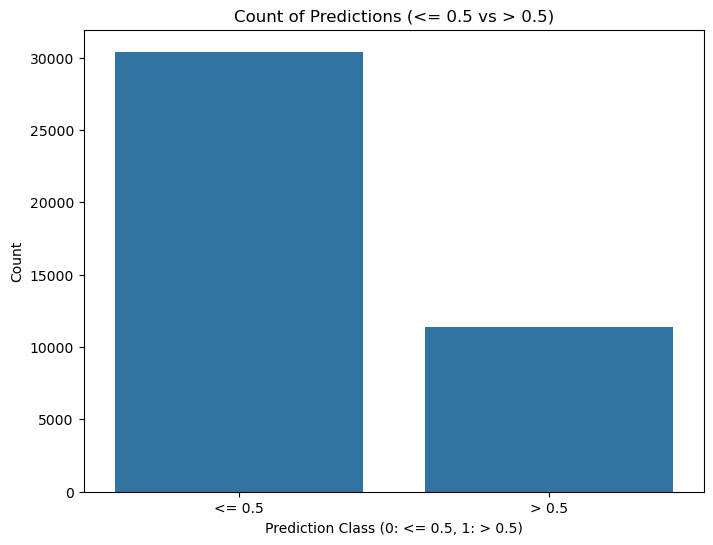

In [30]:
# Step 1: Basic Information
print("Basic Information:")
print(result_df.info())  # Data types and non-null counts
print("\nSummary Statistics of Predicted Probabilities:")
print(result_df['predicted_probability'].describe())  # Descriptive statistics

# Step 2: Distribution of Predicted Probabilities
plt.figure(figsize=(10, 6))
sns.histplot(result_df['predicted_probability'], kde=True, bins=50)
plt.title('Distribution of Predicted Probabilities')
plt.xlabel('Predicted Probability')
plt.ylabel('Frequency')
plt.show()

# Step 3: Checking for any null values
print("\nNull Values in result_df:")
print(result_df.isnull().sum())

# Step 4: Checking for duplicate account numbers
print("\nNumber of Duplicate Account Numbers:")
print(result_df['account_number'].duplicated().sum())

# Step 5: Checking the range of predicted probabilities
min_prob = result_df['predicted_probability'].min()
max_prob = result_df['predicted_probability'].max()
print(f"\nMin Probability: {min_prob}")
print(f"Max Probability: {max_prob}")

# Step 6: Count the number of predictions above 0.5 (indicating positive class predictions)
positive_predictions = result_df[result_df['predicted_probability'] > 0.5]
print(f"\nNumber of positive class predictions (> 0.5): {len(positive_predictions)}")

# Step 7: Visualize the distribution of predictions in two categories: <= 0.5 and > 0.5
plt.figure(figsize=(8, 6))
sns.countplot(x=(result_df['predicted_probability'] > 0.5).astype(int))
plt.title('Count of Predictions (<= 0.5 vs > 0.5)')
plt.xlabel('Prediction Class (0: <= 0.5, 1: > 0.5)')
plt.ylabel('Count')
plt.xticks([0, 1], ['<= 0.5', '> 0.5'])
plt.show()
